In [1]:
from textblob import TextBlob
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

import pandas, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers


from warnings import filterwarnings
filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
import pandas as pd 
data = pd.read_csv('datafiniti-hotel-reviews/Datafiniti_Hotel_Reviews.csv')

In [3]:
data["reviews.rating"].replace(1.0, value = "negatif", inplace = True)
data["reviews.rating"].replace(2.0, value = "negatif", inplace = True)
data["reviews.rating"].replace(4.0, value = "pozitif", inplace = True)
data["reviews.rating"].replace(5.0, value = "pozitif", inplace = True)
data = data[(data['reviews.rating'] == "negatif") | (data['reviews.rating'] == "pozitif")] 

In [4]:
df = pd.DataFrame()
df["comment"] = data["reviews.text"]
df["sentiment"] = data["reviews.rating"]

In [5]:
#buyuk-kucuk donusumu
df['comment'] = df['comment'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#noktalama işaretleri
df['comment'] = df['comment'].str.replace('[^\w\s]','')
#sayılar
df['comment'] = df['comment'].str.replace('\d','')
#stopwords
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
sw = stopwords.words('english')
df['comment'] = df['comment'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
#seyreklerin silinmesi
sil = pd.Series(' '.join(df['comment']).split()).value_counts()[-1000:]
df['comment'] = df['comment'].apply(lambda x: " ".join(x for x in x.split() if x not in sil))
#lemmi
from textblob import Word
#nltk.download('wordnet')
df['comment'] = df['comment'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()])) 



In [6]:
train_x, test_x, train_y, test_y = model_selection.train_test_split(df["comment"],
                                                                   df["sentiment"], 
                                                                    random_state = 1)
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
test_y = encoder.fit_transform(test_y)

# özellik çıkarımı yöntemleri 

In [7]:
# count vektor
vectorizer = CountVectorizer() #ilk başta oluşturduğumuz train_x'i bozmamak için yeni vectorizer oluşturduk.
vectorizer.fit(train_x)
x_train_count = vectorizer.transform(train_x)
x_test_count = vectorizer.transform(test_x)

# tf-idf 
tf_idf_word_vectorizer = TfidfVectorizer() #ilk başta oluşturduğumuz train_x'i bozmamak için yeni vectorizer oluşturduk.
tf_idf_word_vectorizer.fit(train_x)
x_train_tf_idf_word = tf_idf_word_vectorizer.transform(train_x)
x_test_tf_idf_word = tf_idf_word_vectorizer.transform(test_x)

# ngram level tf-idf
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range = (2,3))
tf_idf_ngram_vectorizer.fit(train_x)
x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(train_x)
x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.transform(test_x)

# character level tf-idf
tf_idf_chars_vectorizer = TfidfVectorizer(analyzer = "char", ngram_range = (2,3))
tf_idf_chars_vectorizer.fit(train_x)
x_train_tf_idf_chars = tf_idf_chars_vectorizer.transform(train_x)
x_test_tf_idf_chars = tf_idf_chars_vectorizer.transform(test_x)

# """ makine öğrenmesi sınıflandırma algoritmaları """

# """naive bayes"""

In [8]:
nb = naive_bayes.MultinomialNB()
nb_model = nb.fit(x_train_count,train_y)

accuracy4 = model_selection.cross_val_score(nb_model, x_test_count, test_y, cv = 10).mean()
recall4 = model_selection.cross_val_score(nb_model, x_test_count, test_y, cv=10, scoring='recall').mean()
precision4 = model_selection.cross_val_score(nb_model, x_test_count, test_y, cv=10, scoring='precision').mean()
f1_score4 =  model_selection.cross_val_score(nb_model, x_test_count, test_y, cv=10, scoring='f1_macro').mean()

print("Count Vectors Doğruluk Oranı:", accuracy4)
print("Count Vectors Recall:", recall4)
print("Count Vectors Precision:", precision4)
print("Count Vectors F1 Score:", f1_score4)

Count Vectors Doğruluk Oranı: 0.8989463159513921
Count Vectors Recall: 0.9911764705882353
Count Vectors Precision: 0.9012396294605377
Count Vectors F1 Score: 0.7114292829715505


In [9]:
nb1 = naive_bayes.MultinomialNB()
nb_model1 = nb1.fit(x_train_tf_idf_word,train_y)

accuracy5 = model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv = 10).mean()
recall5 = model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv=10, scoring='recall').mean()
precision5 = model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv=10, scoring='precision').mean()
f1_score5 =  model_selection.cross_val_score(nb_model1, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()

print("Word-Level TF-IDF Doğruluk Oranı:", accuracy5)
print("Word-Level TF-IDF Recall:", recall5)
print("Word-Level TF-IDF Precision:", precision5)
print("Word-Level TF-IDF F1 Score:", f1_score5)

Word-Level TF-IDF Doğruluk Oranı: 0.859526739475978
Word-Level TF-IDF Recall: 1.0
Word-Level TF-IDF Precision: 0.859526739475978
Word-Level TF-IDF F1 Score: 0.46222820669149706


In [10]:
nb2 = naive_bayes.MultinomialNB()
nb_model2 = nb2.fit(x_train_tf_idf_ngram,train_y)

accuracy6 = model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv = 10).mean()
recall6 = model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall').mean()
precision6 = model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision').mean()
f1_score6 =  model_selection.cross_val_score(nb_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()

print("N-GRAM TF-IDF Doğruluk Oranı:", accuracy6)
print("N-GRAM TF-IDF Recall:", recall6)
print("N-GRAM TF-IDF Precision:", precision6)
print("N-GRAM TF-IDF F1 Score:", f1_score6)

N-GRAM TF-IDF Doğruluk Oranı: 0.859526739475978
N-GRAM TF-IDF Recall: 1.0
N-GRAM TF-IDF Precision: 0.859526739475978
N-GRAM TF-IDF F1 Score: 0.46222820669149706


In [11]:
nb3 = naive_bayes.MultinomialNB()
nb_model3 = nb3.fit(x_train_tf_idf_chars,train_y)

accuracy7 = model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv = 10).mean()
recall7 = model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='recall').mean()
precision7 = model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='precision').mean()
f1_score7 =  model_selection.cross_val_score(nb_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='f1_macro').mean()

print("CHARLEVEL TF-IDF Doğruluk Oranı:", accuracy7)
print("CHARLEVEL TF-IDF Recall:", recall7)
print("CHARLEVEL TF-IDF Precision:", precision7)
print("CHARLEVEL TF-IDF F1 Score:", f1_score7)

CHARLEVEL TF-IDF Doğruluk Oranı: 0.859526739475978
CHARLEVEL TF-IDF Recall: 1.0
CHARLEVEL TF-IDF Precision: 0.859526739475978
CHARLEVEL TF-IDF F1 Score: 0.46222820669149706


# """lojistik regresyon"""

In [9]:
loj = linear_model.LogisticRegression()
loj_model = loj.fit(x_train_count, train_y)

accuracy = model_selection.cross_val_score(loj_model, x_test_count, test_y, cv = 10).mean()
recall = model_selection.cross_val_score(loj_model, x_test_count, test_y, cv=10, scoring='recall').mean()
precision = model_selection.cross_val_score(loj_model, x_test_count, test_y, cv=10, scoring='precision').mean()
f1_score =  model_selection.cross_val_score(loj_model, x_test_count, test_y, cv=10, scoring='f1_macro').mean()

print("Count Vectors Doğruluk Oranı:", accuracy)
print("Count Vectors Recall:", recall)
print("Count Vectors Precision:", precision)
print("Count Vectors F1 Score:", f1_score)

Count Vectors Doğruluk Oranı: 0.9181382351433113
Count Vectors Recall: 0.9811902304781561
Count Vectors Precision: 0.9278006900801374
Count Vectors F1 Score: 0.7996170993467435


In [13]:
loj1 = linear_model.LogisticRegression()
loj_model1 = loj1.fit(x_train_tf_idf_word,train_y)

accuracy1 = model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv = 10).mean()
recall1 = model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv=10, scoring='recall').mean()
precision1 = model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv=10, scoring='precision').mean()
f1_score1 =  model_selection.cross_val_score(loj_model1, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()

print("Word-Level TF-IDF Doğruluk Oranı:", accuracy1)
print("Word-Level TF-IDF Recall:", recall1)
print("Word-Level TF-IDF Precision:", precision1)
print("Word-Level TF-IDF F1 Score:", f1_score1)

Word-Level TF-IDF Doğruluk Oranı: 0.8762010972670872
Word-Level TF-IDF Recall: 0.9988235294117647
Word-Level TF-IDF Precision: 0.8749203004557954
Word-Level TF-IDF F1 Score: 0.5756589907274576


In [14]:
loj2 = linear_model.LogisticRegression()
loj_model2 = loj2.fit(x_train_tf_idf_ngram,train_y)

accuracy2 = model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv = 10).mean()
recall2 = model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall').mean()
precision2 = model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision').mean()
f1_score2 =  model_selection.cross_val_score(loj_model2, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()

print("N-GRAM TF-IDF Doğruluk Oranı:", accuracy2)
print("N-GRAM TF-IDF Recall:", recall2)
print("N-GRAM TF-IDF Precision:", precision2)
print("N-GRAM TF-IDF F1 Score:", f1_score2)

N-GRAM TF-IDF Doğruluk Oranı: 0.859526739475978
N-GRAM TF-IDF Recall: 1.0
N-GRAM TF-IDF Precision: 0.859526739475978
N-GRAM TF-IDF F1 Score: 0.46222820669149706


In [15]:
loj3 = linear_model.LogisticRegression()
loj_model3 = loj3.fit(x_train_tf_idf_chars,train_y)

accuracy3 = model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv = 10).mean()
recall3 = model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='recall').mean()
precision3 = model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='precision').mean()
f1_score3 =  model_selection.cross_val_score(loj_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='f1_macro').mean()

print("CHARLEVEL TF-IDF Doğruluk Oranı:", accuracy3)
print("CHARLEVEL TF-IDF Recall:", recall3)
print("CHARLEVEL TF-IDF Precision:", precision3)
print("CHARLEVEL TF-IDF F1 Score:", f1_score3)

CHARLEVEL TF-IDF Doğruluk Oranı: 0.8878172588832488
CHARLEVEL TF-IDF Recall: 0.9982352941176471
CHARLEVEL TF-IDF Precision: 0.8859273127195824
CHARLEVEL TF-IDF F1 Score: 0.6379120720630869


# """random forest"""

In [10]:
rf = ensemble.RandomForestClassifier()
rf_model = rf.fit(x_train_count,train_y)

accuracy8 = model_selection.cross_val_score(rf_model, x_test_count, test_y, cv = 10).mean()
recall8 = model_selection.cross_val_score(rf_model, x_test_count, test_y, cv=10, scoring='recall').mean()
precision8 = model_selection.cross_val_score(rf_model, x_test_count, test_y, cv=10, scoring='precision').mean()
f1_score8 =  model_selection.cross_val_score(rf_model, x_test_count, test_y, cv=10, scoring='f1_macro').mean()

print("Count Vectors Doğruluk Oranı:", accuracy8)
print("Count Vectors Recall:", recall8)
print("Count Vectors Precision:", precision8)
print("Count Vectors F1 Score:", f1_score8)

Count Vectors Doğruluk Oranı: 0.8923755319694404
Count Vectors Recall: 0.9952941176470589
Count Vectors Precision: 0.8890536877461187
Count Vectors F1 Score: 0.6623568768424763


In [17]:
rf1 = ensemble.RandomForestClassifier()
rf_model1 = rf1.fit(x_train_tf_idf_word,train_y)

accuracy9 = model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv = 10).mean()
recall9 = model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv=10, scoring='recall').mean()
precision9 = model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv=10, scoring='precision').mean()
f1_score9 =  model_selection.cross_val_score(rf_model1, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()

print("Word-Level TF-IDF Doğruluk Oranı:", accuracy9)
print("Word-Level TF-IDF Recall:", recall9)
print("Word-Level TF-IDF Precision:", precision9)
print("Word-Level TF-IDF F1 Score:", f1_score9)

Word-Level TF-IDF Doğruluk Oranı: 0.8807516792288366
Word-Level TF-IDF Recall: 0.9994117647058823
Word-Level TF-IDF Precision: 0.8804961687112561
Word-Level TF-IDF F1 Score: 0.611834190789268


In [19]:
rf3 = ensemble.RandomForestClassifier()
rf_model3 = rf3.fit(x_train_tf_idf_chars,train_y)

accuracy11 = model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv = 10).mean()
recall11 = model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='recall').mean()
precision11 = model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='precision').mean()
f1_score11 =  model_selection.cross_val_score(rf_model3, x_test_tf_idf_chars, test_y, cv=10, scoring='f1_macro').mean()

print("CHARLEVEL TF-IDF Doğruluk Oranı:", accuracy11)
print("CHARLEVEL TF-IDF Recall:", recall11)
print("CHARLEVEL TF-IDF Precision:", precision11)
print("CHARLEVEL TF-IDF F1 Score:", f1_score11)

CHARLEVEL TF-IDF Doğruluk Oranı: 0.8671050607598831
CHARLEVEL TF-IDF Recall: 0.9994117647058823
CHARLEVEL TF-IDF Precision: 0.8677509250478792
CHARLEVEL TF-IDF F1 Score: 0.4989397846056839


# graph

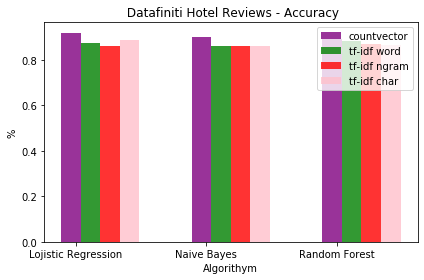

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
cv = (accuracy, accuracy4, accuracy8)
word = (accuracy1, accuracy5, accuracy9)
ngram = (accuracy2, accuracy6, 0.87)
char = (accuracy3, accuracy7, accuracy11)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, cv, bar_width,
alpha=opacity,
color='purple',
label='countvector')

rects2 = plt.bar(index + bar_width, word, bar_width,
alpha=opacity,
color='g',
label='tf-idf word')

rects3 = plt.bar(index + bar_width*2, ngram, bar_width,
alpha=opacity,
color='red',
label='tf-idf ngram')

rects3 = plt.bar(index + bar_width*3, char, bar_width,
alpha=opacity,
color='pink',
label='tf-idf char')

plt.xlabel('Algorithym')
plt.ylabel('%')
plt.title(' Datafiniti Hotel Reviews - Accuracy')
plt.xticks(index + bar_width/4, ('Lojistic Regression', 'Naive Bayes', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()

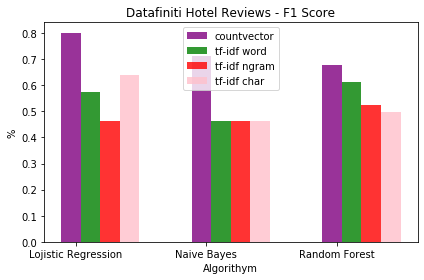

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
cv = (f1_score, f1_score4, f1_score8)
word = (f1_score1, f1_score5, f1_score9)
ngram = (f1_score2, f1_score6, 0.5260)
char = (f1_score3, f1_score7, f1_score11)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, cv, bar_width,
alpha=opacity,
color='purple',
label='countvector')

rects2 = plt.bar(index + bar_width, word, bar_width,
alpha=opacity,
color='g',
label='tf-idf word')

rects3 = plt.bar(index + bar_width*2, ngram, bar_width,
alpha=opacity,
color='red',
label='tf-idf ngram')

rects3 = plt.bar(index + bar_width*3, char, bar_width,
alpha=opacity,
color='pink',
label='tf-idf char')

plt.xlabel('Algorithym')
plt.ylabel('%')
plt.title("Datafiniti Hotel Reviews - F1 Score")
plt.xticks(index + bar_width/4, ('Lojistic Regression', 'Naive Bayes', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()

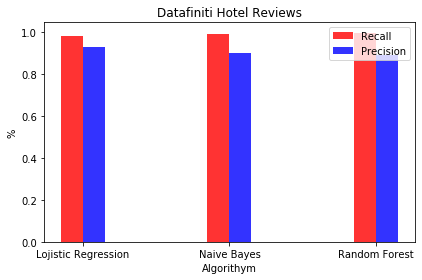

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 3
rc = (recall, recall4, recall8)
pc = (precision, precision4, precision8)

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.15
opacity = 0.8

rects1 = plt.bar(index, rc, bar_width,
alpha=opacity,
color='red',
label='Recall')

rects2 = plt.bar(index + bar_width, pc, bar_width,
alpha=opacity,
color='blue',
label='Precision')


plt.xlabel('Algorithym')
plt.ylabel('%')
plt.title("Datafiniti Hotel Reviews")
plt.xticks(index + bar_width/2, ('Lojistic Regression', 'Naive Bayes', 'Random Forest'))
plt.legend()

plt.tight_layout()
plt.show()